In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
# Constants
SEQUENCE_LEN = 5 * 24              # 5 days of hourly data
OUTPUT_LEN = 1 * 24                # 24 hours in the next day
INPUT_FEATURES = 23                # Number of input features (e.g., temperature, humidity, etc.)
OUTPUT_FEATURES = 5 * OUTPUT_LEN   # Predicting flatten 4 features for each timestamp (wind direction is described as two cols)

In [3]:
def wind_direction_sin_cos(data: pd.DataFrame):
    """ To avoid problem of huge MSE error degrees are replaced by sin and cos functions """
    data['Kierunek wiatru [sin]'] = np.sin(data['Kierunek wiatru  [°]'] * 2 * np.pi / 360)  # transform to radians and calculate sin
    data['Kierunek wiatru [cos]'] = np.cos(data['Kierunek wiatru  [°]'] * 2 * np.pi / 360)  # transform to radians and calculate sin
    data.drop('Kierunek wiatru  [°]', axis=1, inplace=True)
    return data

def create_sequences(data: pd.DataFrame):
    X, y = [], []
    for i in range(len(data) - SEQUENCE_LEN - OUTPUT_LEN):
        X.append(data[i: i + SEQUENCE_LEN])
        y.append(data[i + SEQUENCE_LEN: i + SEQUENCE_LEN + OUTPUT_LEN, :5].flatten()) # Taking the first 4 features for the next 24 hours
    return np.array(X), np.array(y)

def invert_scale_for_X(X: np.ndarray, scaler):
    copy_X = X.copy()
    for i in range(X.shape[-1]):
        print()
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_X[:, :, i] = X[:, :, i] * std + mean
    return copy_X

def invert_scale_for_y(y: np.ndarray, scaler):
    copy_y = y.copy()
    for i in range(5):
        std, mean = scaler.scale_[i], scaler.mean_[i]
        copy_y[:, i::5] = y[:, i::5] * std + mean
    return copy_y

def back_to_degrees_for_X(X: np.ndarray):
    sin_part, cos_part = X[:, :, 2], X[:, :, 3]  # get all 
    X[:, :, 2] = np.arctan2(sin_part, cos_part) * 180 / np.pi
    replaced_X = np.delete(X, 3, axis=2)
    return replaced_X

def back_to_degrees_for_y(y: np.ndarray):
    sin_part, cos_part = y[:, 2::5], y[:, 3::5]  # get all 
    y[:, 2::5] = np.arctan2(sin_part, cos_part) * 180 / np.pi
    replaced_y = np.delete(y, list(range(3, 119, 5)), axis=1)
    return replaced_y

def plot_one_prediction(idx: int, X_true, y_true, y_pred, figsize: Tuple[int] = (14, 9)):
    x = range(-SEQUENCE_LEN, OUTPUT_LEN)
    x1, x2 = x[1:1 + SEQUENCE_LEN], x[SEQUENCE_LEN:]
    labels = ['Temperatura [°C]', 'Ciśnienie atmos. [hPa]', 'Kierunek wiatru [°]', 'Prędkość wiatru [m/s]']

    fig, axs = plt.subplots(4, figsize=figsize)
    fig.suptitle('Porównanie wyników modelu z faktycznym stanem pogody')
    for i in range(4):
        axs[i].plot(x1, X_true[idx + 1, :, i], label='Dane wejściowe', color='green')
        axs[i].plot(x2, y_true[:, i::4][idx], label='Wartość prawdziwa', color='blue')
        axs[i].plot(x2, y_pred[:, i::4][idx], label='Predykcja', color='red')
        axs[i].set_ylabel(labels[i])
        axs[i].grid()
        axs[i].legend()
    axs[3].set_xlabel('Czas [godz.]')
    plt.show()
    
def BIAS(y_true: np.ndarray, y_pred: np.ndarray):
    T_bias = np.mean(y_pred[:, 0::4] - y_true[:, 0::4], axis=0).reshape(1, -1)    # bias for temperature
    P_bias = np.mean(y_pred[:, 1::4] - y_true[:, 1::4], axis=0).reshape(1, -1)    # bias for pressure
    
    WD_diff = np.mod(y_pred[:, 2::4], 360) - np.mod(y_true[:, 2::4], 360)
    WD_diff = np.where(np.abs(WD_diff) > 180, WD_diff - np.sign(WD_diff) * 360, WD_diff)
    WD_bias = np.mean(WD_diff, axis=0).reshape(1, -1)  # bias for wind direction
    
    WV_bias = np.mean(y_pred[:, 3::4] - y_true[:, 3::4], axis=0).reshape(1, -1)   # bias for wind velocity
    
    BIAS_by_hour = np.append(np.append(np.append(T_bias, P_bias, axis=0), WD_bias, axis=0), WV_bias, axis=0)
    return BIAS_by_hour

def MAE(y_true: np.ndarray, y_pred: np.ndarray):
    T_mae = np.mean(np.abs(y_pred[:, 0::4] - y_true[:, 0::4]), axis=0).reshape(1, -1)    # mae for temperature
    P_mae = np.mean(np.abs(y_pred[:, 1::4] - y_true[:, 1::4]), axis=0).reshape(1, -1)    # mae for pressure
    
    WD_diff = np.mod(y_pred[:, 2::4], 360) - np.mod(y_true[:, 2::4], 360)
    WD_diff = np.where(np.abs(WD_diff) > 180, WD_diff - np.sign(WD_diff) * 360, WD_diff)
    WD_mae = np.mean(np.abs(WD_diff), axis=0).reshape(1, -1)  # mae for wind direction
    
    WV_mae = np.mean(np.abs(y_pred[:, 3::4] - y_true[:, 3::4]), axis=0).reshape(1, -1)   # mae for wind velocity
    
    MAE_by_hour = np.append(np.append(np.append(T_mae, P_mae, axis=0), WD_mae, axis=0), WV_mae, axis=0)
    return MAE_by_hour
    
    
def RMSE(y_true: np.ndarray, y_pred: np.ndarray):
    T_mse = np.mean((y_true[:, 0::4] - y_pred[:, 0::4])**2, axis=0).reshape(1, -1)
    P_mse = np.mean((y_true[:, 1::4] - y_pred[:, 1::4])**2, axis=0).reshape(1, -1)
    WD_diff = np.mod(y_pred[:, 2::4], 360) - np.mod(y_true[:, 2::4], 360)
    WD_diff = np.where(np.abs(WD_diff) > 180, WD_diff - np.sign(WD_diff) * 360, WD_diff)
    WD_mse = np.mean(WD_diff**2, axis=0).reshape(1, -1)  # bias for wind direction
    WV_mse = np.mean((y_true[:, 3::4] - y_pred[:, 3::4])**2, axis=0).reshape(1, -1)
    MSE_by_hour = np.append(np.append(np.append(T_mse, P_mse, axis=0), WD_mse, axis=0), WV_mse, axis=0)
    
    return np.sqrt(MSE_by_hour)

In [4]:
data = pd.read_csv('../data/preprocessed_data/complete_krk_2017-22.csv')
data = data.drop('timestamp', axis=1)
data = wind_direction_sin_cos(data)
data

,Temperatura powietrza [°C]/1,Ciśnienie na poziomie stacji [hPa],Ciśnienie na poziomie morza [hPa],Ciśnienie pary wodnej [hPa],Widzialność operatora [m],Zachmurzenie ogólne [oktanty],Zachmurzenie niskie [oktanty],Chmury CL [kod],Chmury CM [kod],Chmury CH [kod],...,Wilgotność względna [%],Niedosyt wilgotności [hPa],Wystąpienie rosy [0/1],Wartość tendencji [wartość],Opad godzinowy [mm],Rodzaj opadu za 6 godzin [kod],Wysokość pokrywy śnieżnej [cm],Gatunek śniegu [kod],Kierunek wiatru [sin],Kierunek wiatru [cos]
0,-6.8,995.8,1027.1,3.5,3500,0,0,0,0,0,...,95,0.2,0,-1.5,0.0,0.0,0.0,0,-0.052336,0.998630
1,-6.9,995.6,1026.9,3.5,3500,0,0,0,0,0,...,95,0.2,0,-1.4,0.0,0.0,0.0,0,0.990268,-0.139173
2,-3.9,994.9,1025.8,3.8,5000,0,0,0,0,0,...,83,0.8,0,-1.4,0.0,0.0,0.0,0,-0.422618,-0.906308
3,-6.5,994.1,1025.3,3.5,4000,0,0,0,0,0,...,92,0.3,0,-1.7,0.0,0.0,0.0,0,-0.515038,-0.857167
4,-6.1,993.6,1024.8,3.3,4000,0,0,0,0,0,...,85,0.6,0,-2.0,0.0,0.0,0.0,0,0.207912,-0.978148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,8.3,991.2,1020.7,9.5,20000,7,0,0,0,0,...,87,1.4,0,0.7,0.0,0.0,0.0,0,-0.939693,-0.342020
52580,9.1,991.4,1020.8,9.2,20000,7,0,0,0,0,...,80,2.3,0,0.5,0.0,0.0,0.0,0,-0.829038,-0.559193
52581,8.4,991.6,1021.1,9.0,20000,7,0,0,0,0,...,82,2.0,0,0.5,0.0,0.0,0.0,0,-0.342020,-0.939693
52582,9.3,991.6,1021.0,8.7,20000,7,0,0,0,0,...,74,3.0,0,0.4,0.0,0.0,0.0,0,-0.990268,-0.139173


In [5]:
cols = data.columns
new_order = [0, 1, 21, 22, 11] + list(range(2, 11)) + list(range(12, 21))
cols = [cols[i] for i in new_order]
data = data[cols]
data

,Temperatura powietrza [°C]/1,Ciśnienie na poziomie stacji [hPa],Kierunek wiatru [sin],Kierunek wiatru [cos],Prędkość wiatru [m/s],Ciśnienie na poziomie morza [hPa],Ciśnienie pary wodnej [hPa],Widzialność operatora [m],Zachmurzenie ogólne [oktanty],Zachmurzenie niskie [oktanty],...,Wysokość podstawy chmur CL CM szyfrowana [kod],Temperatura punktu rosy [°C],Wilgotność względna [%],Niedosyt wilgotności [hPa],Wystąpienie rosy [0/1],Wartość tendencji [wartość],Opad godzinowy [mm],Rodzaj opadu za 6 godzin [kod],Wysokość pokrywy śnieżnej [cm],Gatunek śniegu [kod]
0,-6.8,995.8,-0.052336,0.998630,1,1027.1,3.5,3500,0,0,...,9,-7.5,95,0.2,0,-1.5,0.0,0.0,0.0,0
1,-6.9,995.6,0.990268,-0.139173,1,1026.9,3.5,3500,0,0,...,9,-7.6,95,0.2,0,-1.4,0.0,0.0,0.0,0
2,-3.9,994.9,-0.422618,-0.906308,3,1025.8,3.8,5000,0,0,...,9,-6.4,83,0.8,0,-1.4,0.0,0.0,0.0,0
3,-6.5,994.1,-0.515038,-0.857167,2,1025.3,3.5,4000,0,0,...,9,-7.6,92,0.3,0,-1.7,0.0,0.0,0.0,0
4,-6.1,993.6,0.207912,-0.978148,1,1024.8,3.3,4000,0,0,...,9,-8.2,85,0.6,0,-2.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,8.3,991.2,-0.939693,-0.342020,3,1020.7,9.5,20000,7,0,...,9,6.3,87,1.4,0,0.7,0.0,0.0,0.0,0
52580,9.1,991.4,-0.829038,-0.559193,3,1020.8,9.2,20000,7,0,...,9,5.8,80,2.3,0,0.5,0.0,0.0,0.0,0
52581,8.4,991.6,-0.342020,-0.939693,2,1021.1,9.0,20000,7,0,...,9,5.5,82,2.0,0,0.5,0.0,0.0,0.0,0
52582,9.3,991.6,-0.990268,-0.139173,2,1021.0,8.7,20000,7,0,...,9,4.9,74,3.0,0,0.4,0.0,0.0,0.0,0


In [6]:
# Assuming 'data' is your dataset with shape (total_hours, 26_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
data_normalized

array([[-1.84487084,  0.96334401,  0.20771005, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [-1.85603007,  0.93829589,  1.79956292, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [-1.52125303,  0.85062749, -0.35763876, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       ...,
       [-0.14866714,  0.43733359, -0.23458116, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [-0.04823402,  0.43733359, -1.22432923, ..., -0.6736711 ,
        -0.15217187, -0.28491282],
       [-0.40532954,  0.42480953,  1.53830215, ..., -0.6736711 ,
        -0.15217187, -0.28491282]])

In [7]:
# Create sequences
X, y = create_sequences(data_normalized)

In [8]:
train_size = 24 * (365 * 3 + 366) # train data includes first 4 years (2017-20)
val_size = 24 * 365               # validation data includes the next 2021 year  
test_size = 24 * 365              # test data includes the last 2022 year

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [9]:
# Define the model
model = Sequential()

# LSTM layers
model.add(LSTM(96, return_sequences=True, input_shape=(SEQUENCE_LEN, INPUT_FEATURES)))
model.add(LSTM(172, return_sequences=False))
# Dense layer
model.add(Dense(128, activation='ReLU'))
# Dropout layer to prevent overfitting
model.add(Dropout(0.2))
# Output layer
model.add(Dense(OUTPUT_FEATURES, activation='linear'))  # 'linear' activation for regression tasks

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 96)           46080     
                                                                 
 lstm_1 (LSTM)               (None, 172)               185072    
                                                                 
 dense (Dense)               (None, 128)               22144     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               15480     
                                                                 
Total params: 268776 (1.03 MB)
Trainable params: 268776 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
1096/1096 [==============================] - 258s 231ms/step - loss: 0.4981 - val_loss: 0.4752
Epoch 2/10
1096/1096 [==============================] - 265s 242ms/step - loss: 0.3813 - val_loss: 0.5602
Epoch 3/10
1096/1096 [==============================] - 269s 246ms/step - loss: 0.3013 - val_loss: 0.5812
Epoch 4/10
1096/1096 [==============================] - 274s 250ms/step - loss: 0.2619 - val_loss: 0.6102
Epoch 5/10
1096/1096 [==============================] - 273s 249ms/step - loss: 0.2431 - val_loss: 0.6141
Epoch 6/10
1096/1096 [==============================] - 272s 248ms/step - loss: 0.2328 - val_loss: 0.6354
Epoch 7/10
1096/1096 [==============================] - 273s 249ms/step - loss: 0.2250 - val_loss: 0.6262
Epoch 8/10
1096/1096 [==============================] - 272s 248ms/step - loss: 0.2186 - val_loss: 0.6252
Epoch 9/10
1096/1096 [==============================] - 269s 245ms/step - loss: 0.2150 - val_loss: 0.6392
Epoch 10/10
1096/1096 [=======================

In [11]:
model.save('LSTM_07-01-2024_final')

INFO:tensorflow:Assets written to: LSTM_07-01-2024_final\assets


INFO:tensorflow:Assets written to: LSTM_07-01-2024_final\assets


In [9]:

from keras.models import load_model

model = load_model('LSTM_07-01-2024_final')


In [10]:
# Make predictions
y_pred = model.predict(X_test)

270/270 [==============================] - 22s 75ms/step


In [11]:
inv_y_pred = invert_scale_for_y(y_pred, scaler)
real_y_pred = back_to_degrees_for_y(inv_y_pred)

inv_y_test = invert_scale_for_y(y_test, scaler)
real_y_test = back_to_degrees_for_y(inv_y_test)

inv_X_test = invert_scale_for_X(X_test, scaler)
real_X_test = back_to_degrees_for_X(inv_X_test)

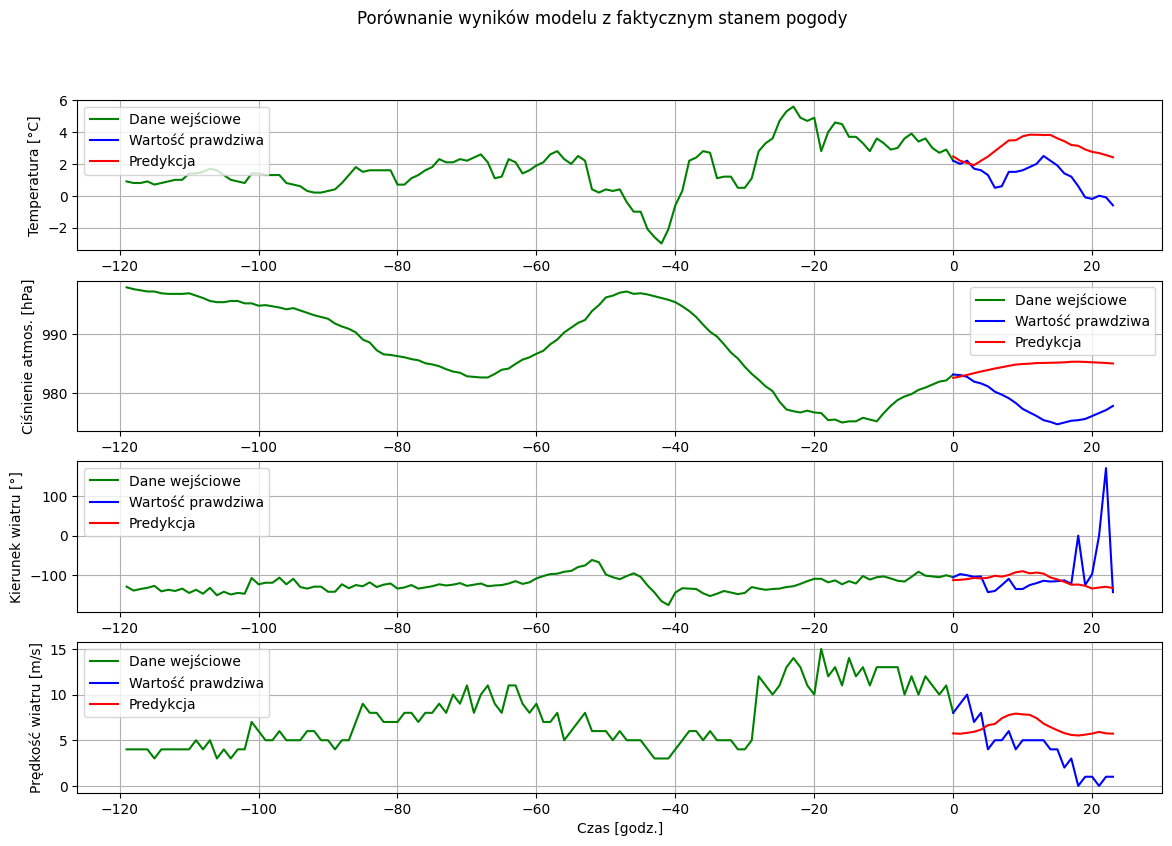

In [23]:
plot_one_prediction(600, real_X_test, real_y_test, real_y_pred)

In [103]:
bias_24h = BIAS(real_y_test, real_y_pred)
bias_24h

array([[-2.09703563e-02, -2.21780987e-02, -6.23124512e-02,
        -1.06406534e-01, -4.98480818e-02, -7.77035089e-02,
        -6.77533569e-02, -4.13260734e-02, -2.43780490e-02,
        -3.46988134e-02,  5.05876900e-03,  5.76588565e-02,
         5.91086904e-02,  7.31318305e-02,  8.46358844e-02,
         1.22455505e-01,  1.27757713e-01,  1.30477799e-01,
         1.79327879e-01,  1.58214607e-01,  1.85217279e-01,
         1.81383141e-01,  1.64045060e-01,  8.52840889e-02],
       [ 1.49909513e-02,  1.25291461e-02,  1.48875769e-03,
        -1.06554745e-02, -3.76808046e-02, -7.06523743e-02,
        -1.01345233e-01, -1.45764869e-01, -1.70506210e-01,
        -1.90732686e-01, -2.24254518e-01, -2.76462213e-01,
        -3.04676521e-01, -3.47719356e-01, -3.91953046e-01,
        -4.44231148e-01, -4.94093549e-01, -5.56721038e-01,
        -6.00554852e-01, -6.61623624e-01, -7.17116101e-01,
        -7.60014527e-01, -7.83003412e-01, -8.25470346e-01],
       [-1.42919668e+00, -2.32160738e-01,  8.93897608e

In [104]:
mae_24h = MAE(real_y_test, real_y_pred)
mae_24h

array([[ 1.78618395,  1.86815001,  1.95920882,  2.04818658,  2.1264879 ,
         2.20256532,  2.26339879,  2.32270287,  2.37091074,  2.40865645,
         2.43719228,  2.460476  ,  2.4812339 ,  2.49288953,  2.5040828 ,
         2.51595641,  2.53500136,  2.55660396,  2.58404739,  2.60679571,
         2.63601075,  2.65736511,  2.68904358,  2.72442938],
       [ 1.27306283,  1.31717897,  1.39506281,  1.49446872,  1.61297334,
         1.74305707,  1.88320085,  2.03280715,  2.18716998,  2.3457213 ,
         2.51112351,  2.68422901,  2.85817966,  3.02803353,  3.19558671,
         3.35835131,  3.51663128,  3.67154125,  3.81654616,  3.95623064,
         4.08608987,  4.21093176,  4.32705025,  4.44168175],
       [50.28477178, 52.33783029, 53.72568223, 55.18068016, 56.1856101 ,
        57.29340651, 57.73551842, 58.91651772, 59.36259346, 59.91322859,
        60.68903128, 61.66960549, 62.17694132, 62.44768803, 62.8710635 ,
        63.68049156, 64.06232986, 64.91079871, 65.11339023, 65.39224602,
  

In [105]:
rmse_24h = RMSE(real_y_test, real_y_pred)
rmse_24h

array([[ 2.29584574,  2.40246613,  2.52316322,  2.63939306,  2.74179793,
         2.83816104,  2.92264111,  3.00352122,  3.06485675,  3.1126956 ,
         3.14501066,  3.17332445,  3.19694847,  3.21182352,  3.22618828,
         3.24210354,  3.26684435,  3.29513666,  3.33041291,  3.35596031,
         3.38713258,  3.4114077 ,  3.44601589,  3.48503546],
       [ 1.68670768,  1.75178995,  1.86415736,  2.00723321,  2.17538816,
         2.35970462,  2.55646412,  2.76523088,  2.98135699,  3.20003915,
         3.4206005 ,  3.6449324 ,  3.86879668,  4.08782163,  4.30287796,
         4.51151796,  4.7119421 ,  4.9026766 ,  5.08111371,  5.24904298,
         5.40554308,  5.55473227,  5.6937918 ,  5.82999959],
       [70.54540264, 73.16619841, 74.50950728, 76.0532265 , 77.06001102,
        78.28860793, 78.51776156, 80.04786137, 80.32041416, 80.90884794,
        81.35786883, 82.65437009, 82.92889909, 82.93597335, 83.54957119,
        84.24483872, 84.52047133, 85.50778891, 85.44113217, 85.75053632,
  

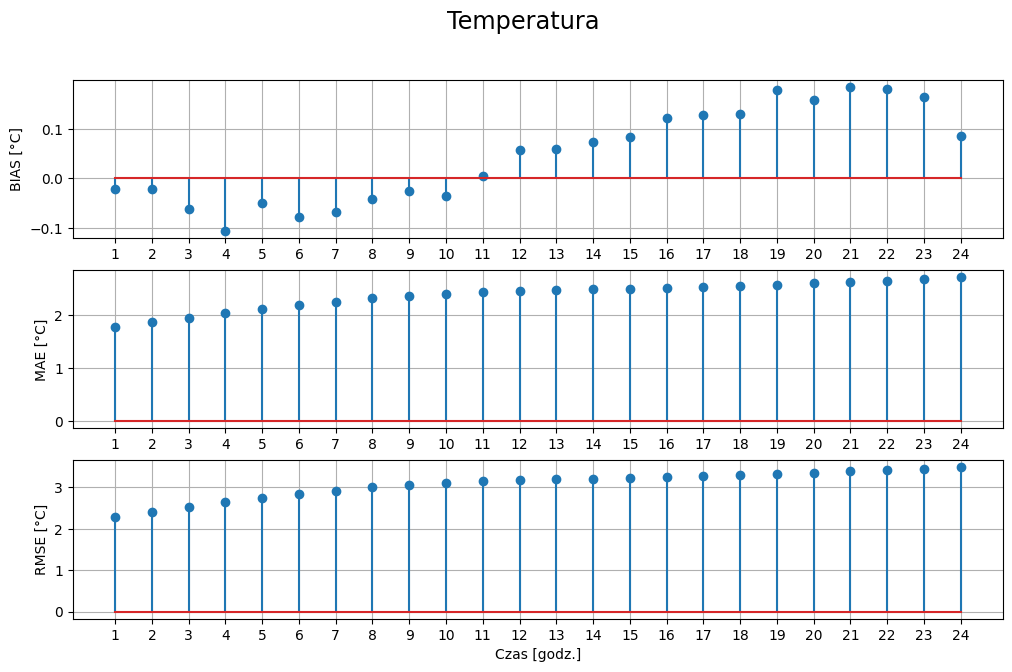

In [106]:
x = range(1, OUTPUT_LEN+1)
fig, axs = plt.subplots(3, figsize=(12, 7))
fig.suptitle('Temperatura', fontsize='xx-large')
axs[0].stem(x, bias_24h[0])
axs[0].set_ylabel('BIAS [°C]')
axs[0].grid()
axs[0].set_xticks(x)
axs[1].stem(x, mae_24h[0])
axs[1].set_ylabel('MAE [°C]')
axs[1].grid()
axs[1].set_xticks(x)
axs[2].stem(x, rmse_24h[0])
axs[2].set_ylabel('RMSE [°C]')
axs[2].grid()
axs[2].set_xlabel('Czas [godz.]')
axs[2].set_xticks(x)
plt.show()

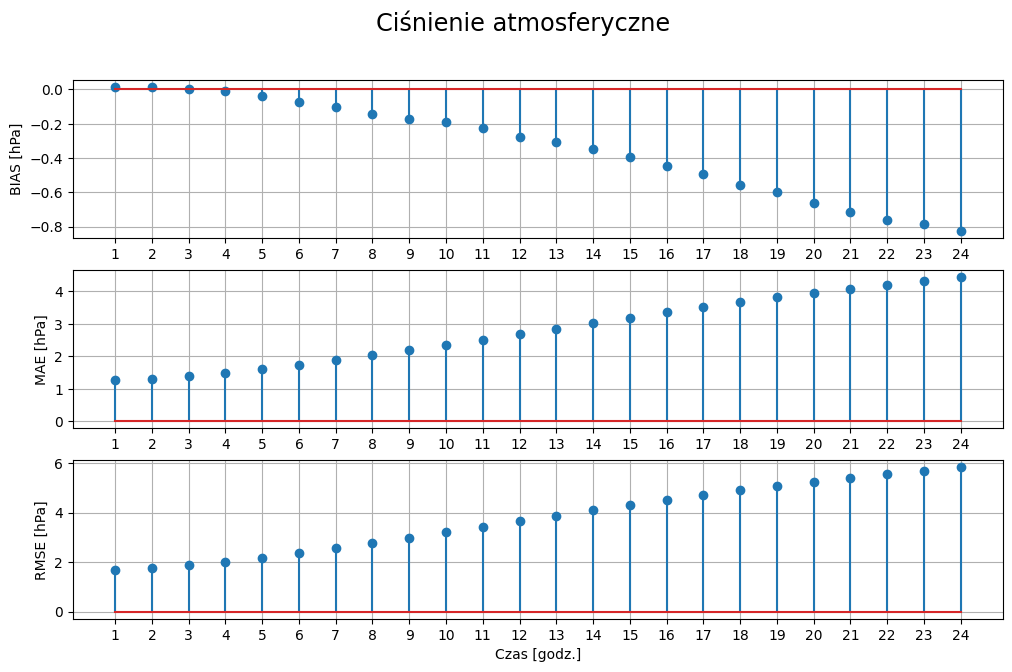

In [107]:
x = range(1, OUTPUT_LEN+1)
fig, axs = plt.subplots(3, figsize=(12, 7))
fig.suptitle('Ciśnienie atmosferyczne', fontsize='xx-large')
axs[0].stem(x, bias_24h[1])
axs[0].set_ylabel('BIAS [hPa]')
axs[0].grid()
axs[0].set_xticks(x)
axs[1].stem(x, mae_24h[1])
axs[1].set_ylabel('MAE [hPa]')
axs[1].grid()
axs[1].set_xticks(x)
axs[2].stem(x, rmse_24h[1])
axs[2].set_ylabel('RMSE [hPa]')
axs[2].grid()
axs[2].set_xlabel('Czas [godz.]')
axs[2].set_xticks(x)
plt.show()

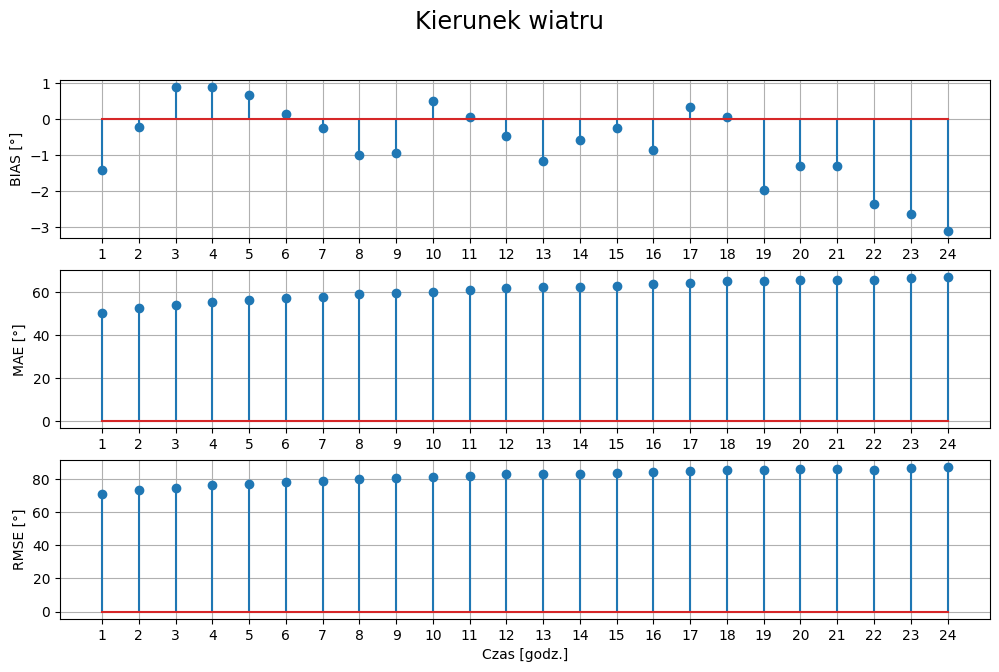

In [108]:
x = range(1, OUTPUT_LEN+1)
fig, axs = plt.subplots(3, figsize=(12, 7))
fig.suptitle('Kierunek wiatru', fontsize='xx-large')
axs[0].stem(x, bias_24h[2])
axs[0].set_ylabel('BIAS [°]')
axs[0].grid()
axs[0].set_xticks(x)
axs[1].stem(x, mae_24h[2])
axs[1].set_ylabel('MAE [°]')
axs[1].grid()
axs[1].set_xticks(x)
axs[2].stem(x, rmse_24h[2])
axs[2].set_ylabel('RMSE [°]')
axs[2].grid()
axs[2].set_xlabel('Czas [godz.]')
axs[2].set_xticks(x)
plt.show()

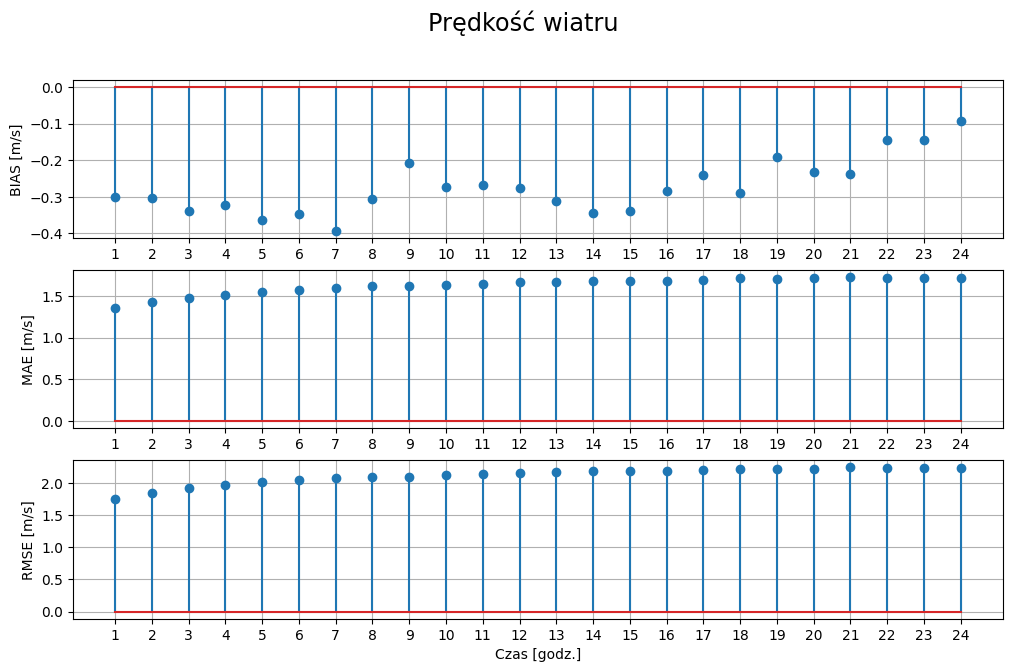

In [109]:
x = range(1, OUTPUT_LEN+1)
fig, axs = plt.subplots(3, figsize=(12, 7))
fig.suptitle('Prędkość wiatru', fontsize='xx-large')
axs[0].stem(x, bias_24h[3])
axs[0].set_ylabel('BIAS [m/s]')
axs[0].grid()
axs[0].set_xticks(x)
axs[1].stem(x, mae_24h[3])
axs[1].set_ylabel('MAE [m/s]')
axs[1].grid()
axs[1].set_xticks(x)
axs[2].stem(x, rmse_24h[3])
axs[2].set_ylabel('RMSE [m/s]')
axs[2].grid()
axs[2].set_xlabel('Czas [godz.]')
axs[2].set_xticks(x)
plt.show()